## **Healthcare Expenditure versus Outcomes: A Comparative Analysis**
### UN5550 Final Project: Group Too
*Suphanat Juengprasertsak, Sabina Bimbi, Terence Mpofu, Connor Donahue*

### **Import relevant packages**

In [98]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols

### **Data loading and preprocessing**
We took the following steps to process our data before performing an analysis:
1. Read data from three CSV files, one with each indicator we are analyzing, into pandas dataframe structures
    - 'a_mort': Adult mortality rate (probability of dying between 15 and 60 years per 1000 population). Source:  https://www.who.int/data/gho/data/indicators/indicator-details/GHO/adult-mortality-rate-(probability-of-dying-between-15-and-60-years-per-1000-population)
    - 'h_mort': Dying between the exact ages 30 and 70 years from cardiovascular diseases, cancer, diabetes, or chronic respiratory diseases (% Probability). Source: https://www.who.int/data/gho/data/indicators/indicator-details/GHO/probability-of-dying-between-exact-ages-30-and-70-from-any-of-cardiovascular-disease-cancer-diabetes-or-chronic-respiratory-(-)
    - 'expended': Current health expenditure (CHE) per capita in US$. Source: https://www.who.int/data/gho/data/indicators/indicator-details/GHO/current-health-expenditure-(che)-per-capita-in-us-dollar

In [99]:
# read csv files into separate dataframes
a_mort = pd.read_csv("adult_mortality_15_to_60.csv", 
            names = ['Country', 'Year', 'Sex', 'Mort_a_15_60'], 
            usecols = [7, 9, 12, 23], 
            skiprows = 1)
h_mort = pd.read_csv("health_mortality_30_to_70.csv", 
            names = ['Country', 'Year', 'Sex', 'Mort_h_30_70'], 
            usecols = [7, 9, 12, 23], 
            skiprows = 1)
expended = pd.read_csv("healthcare_expenditure_per_capita.csv", 
            names = ['Country', 'Year', 'health_expend_per_c'], 
            usecols = [7, 9, 23], 
            skiprows = 1)

2. Selected only data recorded for both sexes

In [100]:
# select only rows representing data for both sexes combined
a_mort_f = a_mort[a_mort['Sex'] == 'Both sexes'].drop('Sex', axis = 1)
h_mort_f = h_mort[h_mort['Sex'] == 'Both sexes'].drop('Sex', axis = 1)

3. Joined each dataframe together on the 'Year' and 'Country' features

In [101]:
# inner join on countries
aggregated = pd.merge(pd.merge(a_mort_f, h_mort_f), expended)
agg_unique_countries = aggregated['Country'].unique()
a_countries = a_mort['Country'].unique()
h_countries = h_mort['Country'].unique()
e_countries = expended['Country'].unique()

4. Recorded total unique countries in the data before and after joining the dataframes

In [102]:
unique_total_countries = set(np.concatenate((a_countries, h_countries, e_countries)))
lost_countries = unique_total_countries.difference(agg_unique_countries)
print(f"""{len(unique_total_countries)} unique countries before joining data, 
and {len(agg_unique_countries)} unique countries after joining. Dropped countries are {lost_countries}\n""")

196 unique countries before joining data, 
and 183 unique countries after joining. Dropped countries are {'Puerto Rico', 'Palau', 'Saint Kitts and Nevis', 'Dominica', 'Cook Islands', 'Marshall Islands', 'San Marino', 'Andorra', 'Niue', 'Monaco', "Democratic People's Republic of Korea", 'Nauru', 'Tuvalu'}



The dropped countries are all remote or inaccessible, and most have very small populations. For this reason, we believe that they would likely be outliers in our analysis because their unique locations, lack of data transparency (e.g. DPRK), and small populations present confounding variables. Due to their lack of available data, however, we are unable to truly classify them as outliers. Therefore, we find it acceptable to exclude them from the analysis.  

5. Selected only data from the year 2019
    - The most recent year with data available for all indicators is 2021, which is during the COVID-19 pandemic. For this reason, we decided to use the data from 2019 because it doesn’t cover the pandemic era and can better reflect the health outcomes of each nation under normal conditions.

In [103]:
# select only data from the year 2019
aggregated_f = aggregated[aggregated['Year'] == 2019].reset_index().drop(columns=['index'])

6. Searched for missing values
    - We did not find any missing values

In [104]:
# if there are missing values, print countries with missing values and drop rows with NAs
print('Missing values:')
print(aggregated_f.isna().sum())

# there are no missing values 

# display a sample of the data
aggregated_f.head(10)

Missing values:
Country                0
Year                   0
Mort_a_15_60           0
Mort_h_30_70           0
health_expend_per_c    0
dtype: int64


,Country,Year,Mort_a_15_60,Mort_h_30_70,health_expend_per_c
0,Cuba,2019,100.10,16.8,1023.0
1,Estonia,2019,99.77,15.1,1599.0
2,Montenegro,2019,100.40,20.9,754.8
3,Azerbaijan,2019,100.80,19.3,199.3
4,Brunei Darussalam,2019,101.20,15.2,677.8
5,Ecuador,2019,101.30,11.5,484.5
6,Slovakia,2019,101.60,16.7,1342.0
7,Sri Lanka,2019,101.90,15.6,154.9
8,Argentina,2019,106.10,15.6,1011.0
9,Nicaragua,2019,106.60,12.8,166.5


### **Exploratory data analysis**
1.  We explored the distributions of each indicator with density plots, as well as summary data for the count, mean, standard deviation, minimum value, quartile values, and maximum value of each distribution.
    - From the data presented below, it is clear that none of the distributions are normal. For this reason, we will conduct our correlation analysis using Spearman's nonparametric coefficient.  

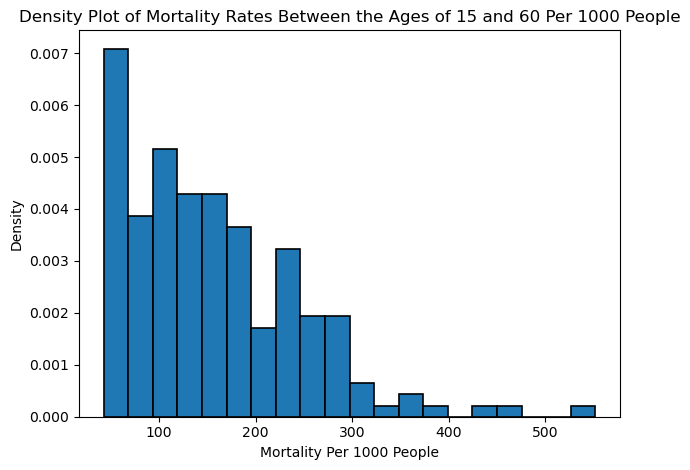

Summary statistics of Mortality Rates Between the Ages of 15 and 60 Per 1000 People: 
count    183.000000
mean     157.220984
std       88.836585
min       42.760000
25%       86.805000
50%      142.000000
75%      210.750000
max      551.800000
Name: Mort_a_15_60, dtype: float64


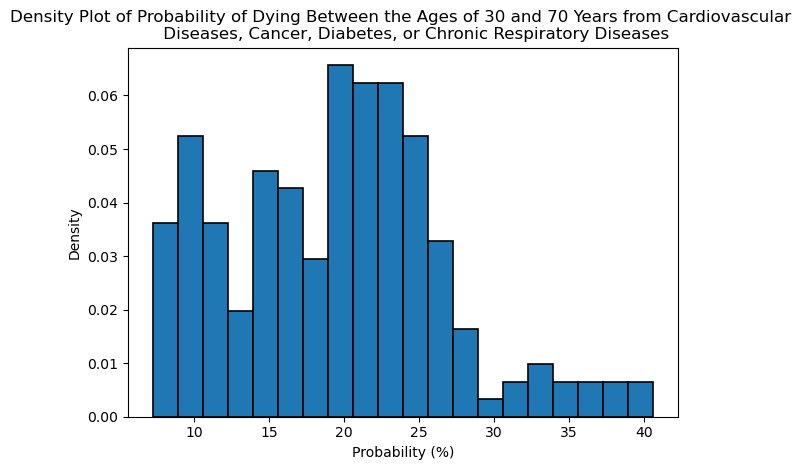

Summary statistics of Probability of Dying Between the Ages of 30 and 70 Years from Cardiovascular
Diseases, Cancer, Diabetes, or Chronic Respiratory Diseases:
count    183.000000
mean      19.485792
std        7.166475
min        7.300000
25%       14.300000
50%       20.300000
75%       23.850000
max       40.600000
Name: Mort_h_30_70, dtype: float64


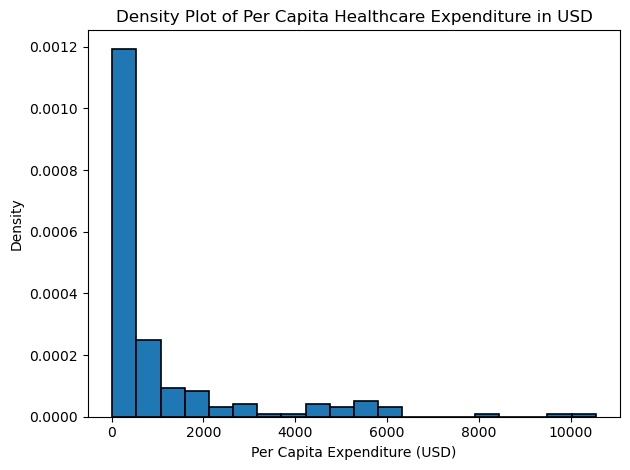

Summary statistics of Per Capita Healthcare Expenditure in USD: 
count      183.000000
mean      1087.842678
std       1834.846800
min         12.870000
25%         69.725000
50%        317.500000
75%       1035.000000
max      10546.000000
Name: health_expend_per_c, dtype: float64


In [105]:
# plot distribution of Mort_a_15_60
plt.figure()
plt.hist(aggregated_f['Mort_a_15_60'], bins = 20, density = 1, edgecolor='black', linewidth=1.2)
plt.title('Density Plot of Mortality Rates Between the Ages of 15 and 60 Per 1000 People')
plt.xlabel('Mortality Per 1000 People')
plt.ylabel('Density')
plt.tight_layout()
plt.show()
# print descriptive summary statistics
print(f"""Summary statistics of Mortality Rates Between the Ages of 15 and 60 Per 1000 People: 
{aggregated_f['Mort_a_15_60'].describe()}""")
    
# plot distribution of Mort_h_30_70
plt.figure()
plt.hist(aggregated_f['Mort_h_30_70'], bins = 20, density = 1, edgecolor='black', linewidth=1.2)
plt.title("""Density Plot of Probability of Dying Between the Ages of 30 and 70 Years from Cardiovascular 
     Diseases, Cancer, Diabetes, or Chronic Respiratory Diseases""")
plt.xlabel('Probability (%)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()
# print descriptive summary statistics
print(f"""Summary statistics of Probability of Dying Between the Ages of 30 and 70 Years from Cardiovascular
Diseases, Cancer, Diabetes, or Chronic Respiratory Diseases:
{aggregated_f['Mort_h_30_70'].describe()}""")
    
# plot distribution of Mort_h_30_70
plt.figure()
plt.hist(aggregated_f['health_expend_per_c'], bins = 20, density = 1, edgecolor='black', linewidth=1.2)
plt.title("Density Plot of Per Capita Healthcare Expenditure in USD")
plt.xlabel('Per Capita Expenditure (USD)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()
# print descriptive summary statistics
print(f"""Summary statistics of Per Capita Healthcare Expenditure in USD: 
{aggregated_f['health_expend_per_c'].describe()}""")



2. Next, we plotted the relationships of both mortality metrics against healthcare expenditure

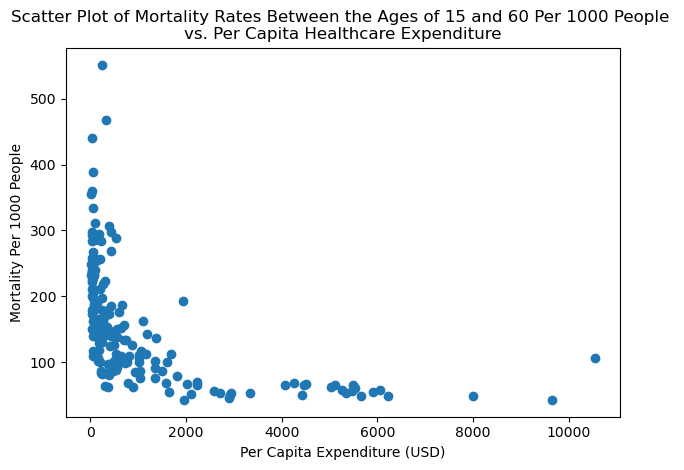

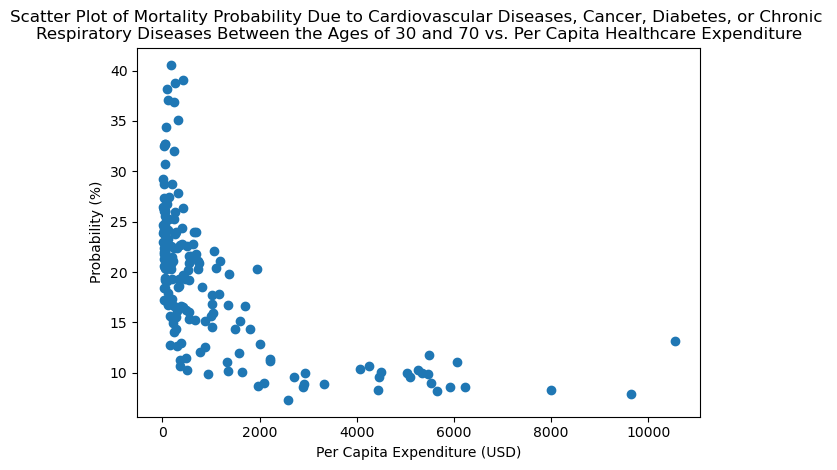

In [106]:
# plot health_expend_per_c vs. Mort_a_15_60
plt.figure()
plt.scatter(aggregated_f['health_expend_per_c'], aggregated_f['Mort_a_15_60'])
plt.title('''Scatter Plot of Mortality Rates Between the Ages of 15 and 60 Per 1000 People 
vs. Per Capita Healthcare Expenditure''')
plt.xlabel('Per Capita Expenditure (USD)')
plt.ylabel('Mortality Per 1000 People')
plt.tight_layout()
plt.show()

# plot health_expend_per_c vs. Mort_h_30_70
plt.figure()
plt.scatter(aggregated_f['health_expend_per_c'], aggregated_f['Mort_h_30_70'])
plt.title("""Scatter Plot of Mortality Probability Due to Cardiovascular Diseases, Cancer, Diabetes, or Chronic 
Respiratory Diseases Between the Ages of 30 and 70 vs. Per Capita Healthcare Expenditure""")
plt.xlabel('Per Capita Expenditure (USD)')
plt.ylabel('Probability (%)')
plt.tight_layout()
plt.show()

3. We found that the above relationships resemble the negative natural logarithm function, so we also plotted the relationships of both mortality metrics against the log of healthcare expenditure.
    - Using the plots below, we observed that the relationship between each mortality metric and log of healthcare expenditure was inverse and fairly linear, so we decided that we will attempt to fit linear regression models on these relationships in our analysis.

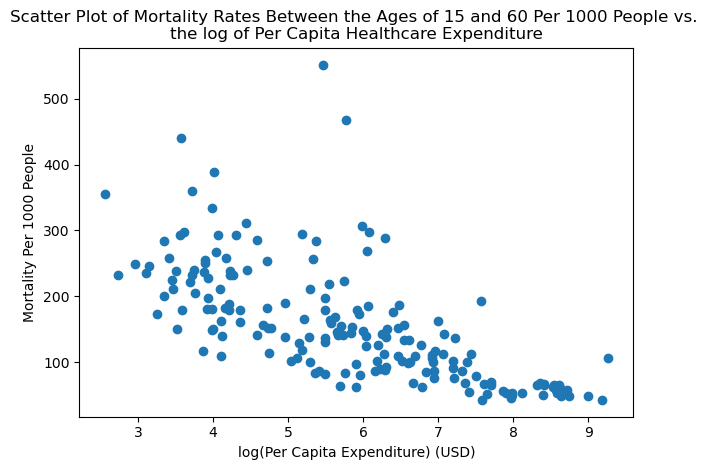

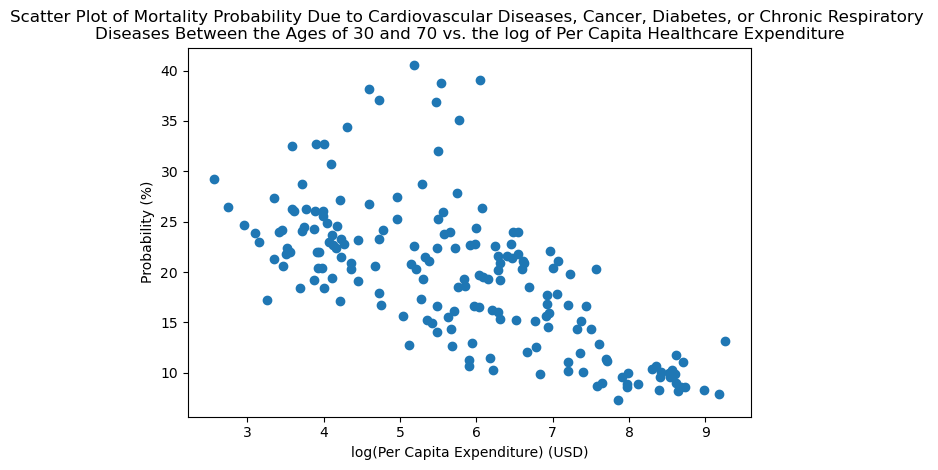

In [107]:
# plot log(health_expend_per_c) vs. Mort_a_15_60
plt.figure()
plt.scatter((np.log(aggregated_f['health_expend_per_c'])), aggregated_f['Mort_a_15_60']) 
plt.title('''Scatter Plot of Mortality Rates Between the Ages of 15 and 60 Per 1000 People vs. 
the log of Per Capita Healthcare Expenditure''')
plt.xlabel('log(Per Capita Expenditure) (USD)')
plt.ylabel('Mortality Per 1000 People')
plt.tight_layout()
plt.show()

# plot log(health_expend_per_c) vs. Mort_h_30_70
plt.figure()
plt.scatter((np.log(aggregated_f['health_expend_per_c'])), aggregated_f['Mort_h_30_70'])
plt.title("""Scatter Plot of Mortality Probability Due to Cardiovascular Diseases, Cancer, Diabetes, or Chronic Respiratory 
Diseases Between the Ages of 30 and 70 vs. the log of Per Capita Healthcare Expenditure""")
plt.xlabel('log(Per Capita Expenditure) (USD)')
plt.ylabel('Probability (%)')
plt.tight_layout()
plt.show()

### **Main analysis: correlation and linear regression**

The main portion of our analysis involves linear regression: 
- We chose to fit a simple linear model with the predictor variable being the natural log of the health expenditure per capita, and the outcome variable as the total mortality rates between the ages of 15 and 60 per 1000 people.
    - We chose simple linear regression because our data only has one predictor variable available. 
    - We observed a very strong linear relationship, with a negative slope, an r-squared of 0.461, and a highly significant p-value (p << 0.001). The r-squared value suggests that 46.1% of the variation in total mortality rates is explained by health expenditure alone. This is a very large and significant amount, which supports our hypothesis that healthcare expenditure is a major factor in the health outcomes and lifespans of individuals in a nation. 

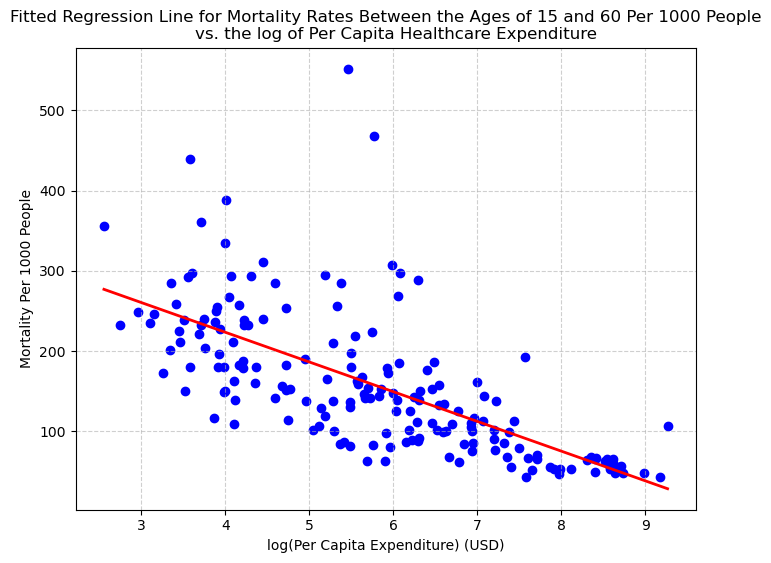

                            OLS Regression Results                            
Dep. Variable:           Mort_a_15_60   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     155.0
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           4.20e-26
Time:                        13:33:41   Log-Likelihood:                -1023.6
No. Observations:                 183   AIC:                             2051.
Df Residuals:                     181   BIC:                             2058.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [108]:
#create dataframe with log of expenditure metric
reg_df = pd.DataFrame({'country' : aggregated_f['Country'],
                      'log_health_expend_per_c' : np.log(aggregated_f['health_expend_per_c']),
                      'Mort_a_15_60' : aggregated_f['Mort_a_15_60'],
                      'Mort_h_30_70' : aggregated_f['Mort_h_30_70']})

#Regression on Log linear on original x-variable('health_expend_per_c')  Mort_a_15_60
model1 = ols('Mort_a_15_60 ~ log_health_expend_per_c', 
            data=reg_df[['log_health_expend_per_c','Mort_a_15_60']]).fit()

# Extract the coefficients
intercept = model1.params['Intercept']
slope_X = model1.params['log_health_expend_per_c']

# Create a range of values for a smooth line
X_range = np.linspace(reg_df['log_health_expend_per_c'].min(), reg_df['log_health_expend_per_c'].max(), 100)

# Calculate the predicted Y values
Y_predicted = intercept + (slope_X * X_range)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(reg_df['log_health_expend_per_c'], reg_df['Mort_a_15_60'], color='blue')

# Plot the regression line
plt.plot(X_range, Y_predicted, color='red', linewidth=2)

plt.title('''Fitted Regression Line for Mortality Rates Between the Ages of 15 and 60 Per 1000 People
    vs. the log of Per Capita Healthcare Expenditure''')
plt.xlabel('log(Per Capita Expenditure) (USD)')
plt.ylabel('Mortality Per 1000 People')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(model1.summary())

#### Residual analysis and outlier detection of our first model
- Below, we plot the residuals of the first linear regression model and identify outliers using the z-statistic (outliers have |z| > 2).
- As the plot demonstrates, the residuals are mostly normally distributed, except for a subset of outliers that cause a slight skew towards higher residual values. Additionally, there is no clear pattern or trend in the residuals. These observations lead us to conclude that the linear regression model is appropriately applied to the data.
- Notably, the outlying nations are all located in Sub-Saharan Africa and have much higher mortality rates than the model predicts based on their reported healthcare expenditure per capita. Some potential causes of this inefficiency may be weak infrastructure or government corruption that results in a mismanagement of the money that is reportedly spent on healthcare.  

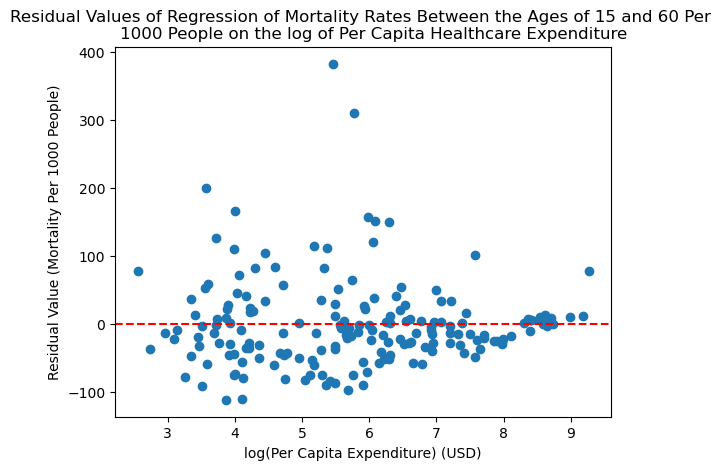

Outlier Residuals:


,country,log_health_expend_per_c,Mort_a_15_60,Mort_h_30_70
114,South Africa,6.289344,288.6,21.6
120,Botswana,6.082904,297.6,19.5
121,Namibia,5.984943,306.8,22.8
131,Eswatini,5.768633,467.7,35.1
144,Lesotho,5.465525,551.8,36.9
126,Zimbabwe,4.009331,388.7,32.7
129,Central African Republic,3.576830,439.7,32.5


In [109]:
#Find residuals from first model
residuals = reg_df['Mort_a_15_60'] - (intercept + (slope_X * reg_df['log_health_expend_per_c']))

#plot residuals
plt.scatter(reg_df['log_health_expend_per_c'], residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title('''Residual Values of Regression of Mortality Rates Between the Ages of 15 and 60 Per 
    1000 People on the log of Per Capita Healthcare Expenditure''')
plt.ylabel('Residual Value (Mortality Per 1000 People)')
plt.xlabel('log(Per Capita Expenditure) (USD)')
plt.show()

# conduct z-test to find outlier residuals
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
z_scores = (residuals - mean_residual) / std_residual

# Identify outliers when Z-score is greater than 2
outliers = reg_df[np.abs(z_scores) > 2]
print('Outlier Residuals:')
outliers.sort_values(by='log_health_expend_per_c', ascending=False)

- We also  fit a simple linear model with the predictor variable being the natural log of the health expenditure per capita, and the outcome variable as mortality probability due to cardiovascular diseases, cancer, diabetes, or chronic respiratory diseases between the ages of 30 and 70.
    - We once again observed a very strong negative linear relationship, with an r-squared of 0.452 and a highly significant p-value (p << 0.001). The r-squared value suggests that 45.2% of the variation in health-related mortality rates is explained by health expenditure alone. This is a very large and significant amount, which supports our hypothesis that healthcare expenditure is a major factor in the health outcomes and lifespans of individuals in a nation. 
    - Notably, the r-squared is greater for the total mortality than it is for this health-related mortality metric. This is an unexpected observation, and it may be due to the greater number of outliers observed for the latter metric. This result will be discussed further in our report.

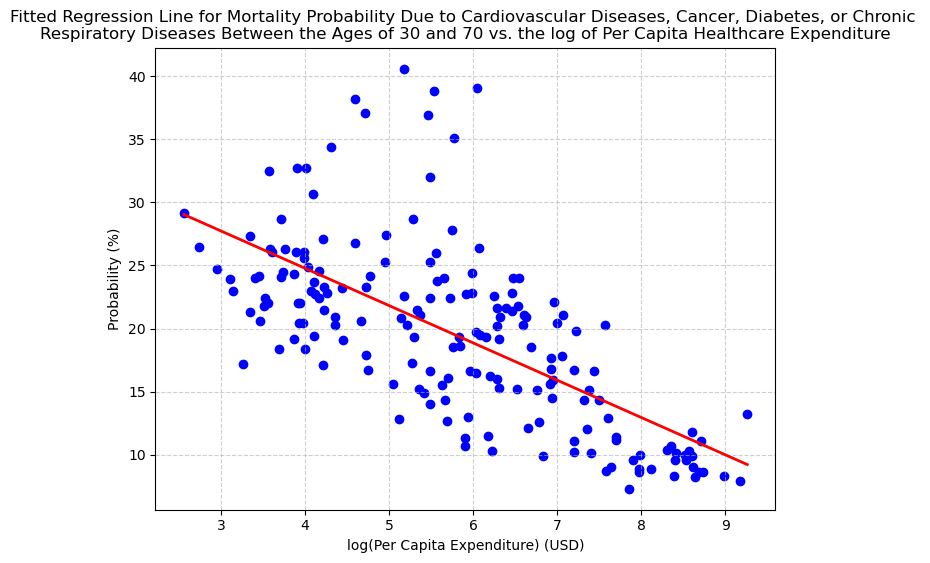

                            OLS Regression Results                            
Dep. Variable:           Mort_h_30_70   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     149.3
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           2.02e-25
Time:                        13:33:41   Log-Likelihood:                -564.54
No. Observations:                 183   AIC:                             1133.
Df Residuals:                     181   BIC:                             1139.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [110]:
#Regression plot on Log linear on original x-variable('health_expend_per_c')  Mort_h_30_70
model2 = ols('Mort_h_30_70 ~ log_health_expend_per_c', 
            data=reg_df[['log_health_expend_per_c','Mort_h_30_70']]).fit()

# 2. Extract the coefficients
intercept = model2.params['Intercept']
slope_X = model2.params['log_health_expend_per_c']

# Create a range of values for a smooth line
X_range = np.linspace(reg_df['log_health_expend_per_c'].min(), reg_df['log_health_expend_per_c'].max(), 100)

# Calculate the predicted Y values
Y_predicted = intercept + (slope_X * X_range)

# 4. Plotting
plt.figure(figsize=(8, 6))
plt.scatter(reg_df['log_health_expend_per_c'], reg_df['Mort_h_30_70'], color='blue')

# Plot the regression line
plt.plot(X_range, Y_predicted, color='red', linewidth=2)

plt.title("""Fitted Regression Line for Mortality Probability Due to Cardiovascular Diseases, Cancer, Diabetes, or Chronic 
Respiratory Diseases Between the Ages of 30 and 70 vs. the log of Per Capita Healthcare Expenditure""")
plt.xlabel('log(Per Capita Expenditure) (USD)')
plt.ylabel('Probability (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(model2.summary())

#### Residual analysis and outlier detection of our second model
- Below, we plot the residuals of the second linear regression model and identify outliers using the z-statistic (outliers have |z| > 2).
- As the plot demonstrates, the residuals are mostly normally distributed, except for a subset of outliers that cause a slight skew towards higher residual values. Additionally, there is no clear pattern or trend in the residuals. These observations lead us to conclude that the linear regression model is appropriately applied to the data.
- Notably, the outliers are all Oceanic or Sub-Saharan nations and have much higher mortality rates than the model predicts based on their reported healthcare expenditure per capita. As noted in the outlier analysis of the previous model, some potential causes of this inefficiency may be weak infrastructure or government corruption that results in a mismanagement of the money that is reportedly spent on healthcare. Specific to Oceanic nations, one potential cause of high expenditures and poor outcomes is the large overhead costs of shipping medical equipment and outsourcing healthcare professionals from other nations.      

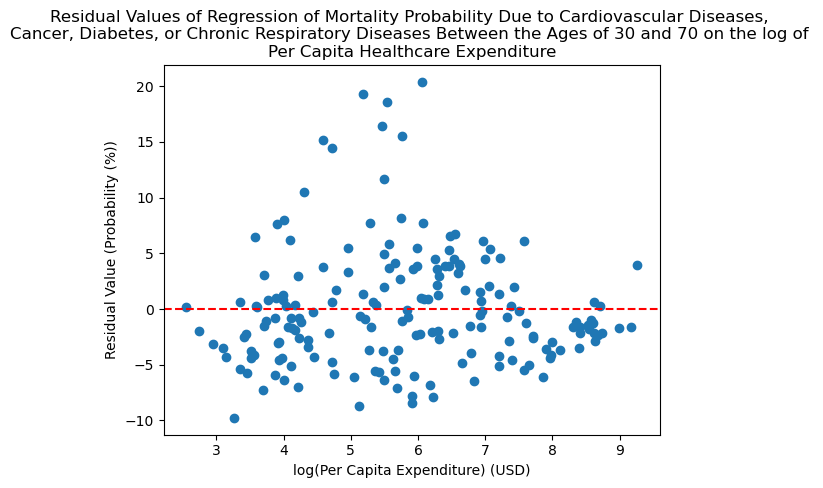

Outlier Residuals:


,country,log_health_expend_per_c,Mort_a_15_60,Mort_h_30_70
110,Micronesia (Federated States of),6.051854,268.2,39.1
131,Eswatini,5.768633,467.7,35.1
86,Fiji,5.540479,218.4,38.8
80,Samoa,5.492650,198.2,32.0
144,Lesotho,5.465525,551.8,36.9
118,Kiribati,5.181222,294.3,40.6
104,Vanuatu,4.719391,254.3,37.1
113,Solomon Islands,4.591781,284.8,38.2


In [111]:
#Find residuals from second model
residuals = reg_df['Mort_h_30_70']- (intercept + (slope_X * reg_df['log_health_expend_per_c'])) 

#plot residuals
plt.scatter(reg_df['log_health_expend_per_c'], residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title('''Residual Values of Regression of Mortality Probability Due to Cardiovascular Diseases, 
Cancer, Diabetes, or Chronic Respiratory Diseases Between the Ages of 30 and 70 on the log of 
Per Capita Healthcare Expenditure''')
plt.ylabel('Residual Value (Probability (%))')
plt.xlabel('log(Per Capita Expenditure) (USD)')
plt.show()

# conduct z-test to find outlier residuals
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
z_scores = (residuals - mean_residual) / std_residual

# Identify outliers when Z-score is greater than 2
outliers = reg_df[np.abs(z_scores) > 2]
print('Outlier Residuals:')
outliers.sort_values(by='log_health_expend_per_c', ascending=False)

- Taken together, both of our regression models imply a strong negative association between the amount of money spent on health care and both total and health-related mortality rates.

In addition to linear regression, we chose to study the correlation between the expenditure metric and each mortality metric. Because neither of the mortality metrics were normally distributed, we chose to use Spearman's rank correlation, rather than Pearson's correlation coefficient.
- In both cases, we observed significant correlations, with a coefficient of -0.775 between health expenditure per capita and total mortality rates between the ages of 15 and 60 (per 1000 people) (p << 0.001). The coefficient for health expenditure per capita correlated with mortality probability due to cardiovascular diseases, cancer, diabetes, or chronic respiratory diseases between the ages of 30 and 70 was -0.714 (p << 0.001).
- These findings lend further support the the validity of our regression result, suggesting that healthcare expenditure is inversely related to mortality rates and health outcomes.

In [112]:
#list of indicators to be correlated
mortality_indicators = [
    'Mort_a_15_60',
    'Mort_h_30_70'
]

# list for storing correlation results
correlation_results = []

# iterate through the two indicators and add the correlation values to a dataframe
for indicator in mortality_indicators:
    
    # spearman correlation
    r_exp, p_exp = spearmanr(aggregated_f[indicator], aggregated_f['health_expend_per_c'])

    correlation_results.append({
        'Mortality_Indicator': indicator,
        'Spearman_r': r_exp,
        'p_value': p_exp,
    })

correlation_df = pd.DataFrame(correlation_results)

# print correlation statistics
print("\n=== Correlation Analysis with p-values ===")
print(correlation_df)


=== Correlation Analysis with p-values ===
  Mortality_Indicator  Spearman_r       p_value
0        Mort_a_15_60   -0.775466  5.435070e-38
1        Mort_h_30_70   -0.713666  8.591927e-30


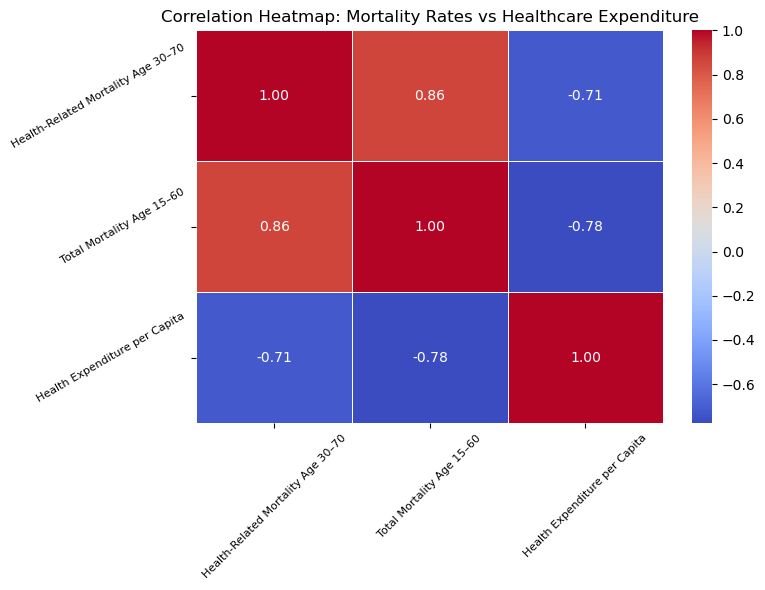

In [113]:
# Rename columns for better plotting
labels = {
    'health_expend_per_c': 'Health Expenditure per Capita',
    'Mort_a_15_60': 'Total Mortality Age 15–60',
    'Mort_h_30_70': 'Health-Related Mortality Age 30–70',
}
renamed_df = aggregated_f[['health_expend_per_c', 'Mort_a_15_60', 'Mort_h_30_70']].rename(columns=labels)


# --- Correlation heatmap for all variables ---
heatmap_cols = ['Health-Related Mortality Age 30–70', 'Total Mortality Age 15–60', 'Health Expenditure per Capita']
corr_matrix = renamed_df[heatmap_cols].corr(method = 'spearman')

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap: Mortality Rates vs Healthcare Expenditure")
plt.xticks(rotation=45, fontsize = 8)
plt.yticks(rotation=30, fontsize = 8)
plt.tight_layout()
plt.show()

### **Conclusions and Findings**

We found that healthcare expenditure per capita is a strong predictor of both total mortality rates (r2 = 0.461, p <<  0.001) and health-related mortality rates (r2 = 0.452, p << 0.001). To further support this claim, we found that health expenditure per capita and total mortality rates between the ages of 15 and 60 have a strong spearman correlation of -0.775 (p << 0.001), and health expenditure per capita also strongly correlated with health-related mortality between the ages of 30 and 70, with a coefficient of -0.714 (p << 0.001). We followed up our regression analysis by extracting outliers, finding that countries in Sub-Saharan Africa and Oceania were frequent outliers that had much higher mortality rates than either model predicted. Notably, there were no outliers for which the mortality rate was significantly lower than the models' predictions.

### **Future Remarks**
Our analysis used a single predictor variable -- healthcare expenditure per capita -- to model mortality metrics tracking the total and health-related mortalities for countries across the globe. Our study can be further expanded in two ways: firstly, a little over half of the variation in mortality rates was not explained by our model; future studies can investigate additional predictor variables in order to better explain the variations in mortality rates. Secondly, we identified a set of outlying nations and speculated as to the cause of their poor healthcare results, but future studies could verify these causes and identify new ones by investigating each outlying country on a case-by-case basis. Overall, our study effectively achieved the goals of quantifying the relationships between mortality and healthcare expenditure and identifying outliers that could be further studied to understand what makes a nation's healthcare system efficient or inefficient. 